# Code to train model on recognizing different hand signs.

In [27]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
import os
MAIN_DIR = os.path.dirname(os.path.abspath('__file__'))
NEURAL_NET_CLASSES_DEF_DIR = os.path.join(os.path.dirname(MAIN_DIR), 'neural_net_classes_definition')
if NEURAL_NET_CLASSES_DEF_DIR not in sys.path:
    sys.path.insert(0, NEURAL_NET_CLASSES_DEF_DIR)
    
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

In [2]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Dataset Generation

In [3]:
#load data
data_dict = pickle.load(open('data.p', 'rb'))

data = data_dict['data']
labels = data_dict['labels']

In [4]:
print(data[0])

[[0.05832335352897644, 0.2713731527328491], [0.12816226482391357, 0.22979044914245605], [0.17347151041030884, 0.13525891304016113], [0.18038368225097656, 0.048344939947128296], [0.2049524486064911, 0.0], [0.13157233595848083, 0.06801262497901917], [0.14688044786453247, 0.023457616567611694], [0.13621479272842407, 0.10200971364974976], [0.12486115097999573, 0.10403621196746826], [0.0810103714466095, 0.07236260175704956], [0.10409009456634521, 0.02603408694267273], [0.10333031415939331, 0.11601272225379944], [0.09187012910842896, 0.11095041036605835], [0.04028859734535217, 0.09250283241271973], [0.058946818113327026, 0.042836785316467285], [0.06903308629989624, 0.12661191821098328], [0.05533486604690552, 0.12728819251060486], [0.0, 0.10645267367362976], [0.017835110425949097, 0.07859385013580322], [0.03176864981651306, 0.1311776041984558], [0.02095264196395874, 0.13616615533828735]]


In [5]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = [torch.tensor(seq, dtype=torch.float32).flatten() for seq in data]
        self.labels = torch.tensor([int(label) for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [6]:
dataset = SignDataset(data, labels)
len(dataset)

8520

In [7]:
landmarks, label = dataset[1000]
print(landmarks)
print(label)

tensor([0.0242, 0.2915, 0.0668, 0.2961, 0.1180, 0.2723, 0.1566, 0.2711, 0.1832,
        0.2909, 0.1006, 0.1621, 0.1063, 0.0913, 0.1066, 0.0433, 0.1054, 0.0000,
        0.0672, 0.1439, 0.0818, 0.1543, 0.0729, 0.2122, 0.0673, 0.2162, 0.0335,
        0.1439, 0.0467, 0.1679, 0.0426, 0.2133, 0.0396, 0.2080, 0.0000, 0.1519,
        0.0115, 0.1704, 0.0137, 0.2079, 0.0098, 0.2081])
tensor(11)


In [8]:
#Split train and validation dataset
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print(len(train_dataset))
print(len(test_dataset))

6816
1704


# DataLoader Generation

In [9]:
train_dataloader = DataLoader(dataset, batch_size = 128, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [10]:
for data, label in train_dataloader:
    break

In [11]:
# 128 datapoints per batch, 21 landmarks [x, y] flatten to become shape 42
# Roughly 10 batches per epoch for training data
print(data.shape)

torch.Size([128, 42])


In [12]:
print(label.shape)

torch.Size([128])


# Neural Network Construction

In [28]:
from neural_net_classes_definition import NeuralNetwork_ver3

In [29]:
model = NeuralNetwork_ver3()
print(model)

NeuralNetwork_ver3(
  (net): Sequential(
    (0): Linear(in_features=42, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=160, bias=True)
    (3): ReLU()
    (4): Linear(in_features=160, out_features=29, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


In [30]:
ex_output = model(data)
ex_output.shape # [batch_size, num_classes]

torch.Size([128, 29])

# Loss & Optimizer

In [31]:
#Loss
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [32]:
criterion(ex_output, label)

tensor(3.3699, grad_fn=<NllLossBackward0>)

In [33]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


# Load Pre-trained Model

In [34]:
def load_checkpoint(filename: str, model: object, optimizer: object) -> (object, object): 
    print("Loading checkpoint")
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    #If save more things, get more from the dict and then return
    return model, optimizer

In [39]:
model, optimizer = load_checkpoint("model_checkpoint_3_1.pth.rar", model, optimizer)

Loading checkpoint


In [40]:
model

NeuralNetwork_ver3(
  (net): Sequential(
    (0): Linear(in_features=42, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=160, bias=True)
    (3): ReLU()
    (4): Linear(in_features=160, out_features=29, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [41]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


# Continue Model Training

In [42]:
num_epochs = 400
train_losses, val_losses = [], []

model.to(DEVICE)

for epoch in range(num_epochs):
    model.train() #setting model mode .train or .eval
    running_loss = 0.0
    for landmarks, labels in tqdm(train_dataloader, desc = "Training loop"):
        landmarks, labels = landmarks.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(landmarks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)

    #Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for landmarks, labels in tqdm(test_dataloader, desc = "Validation loop"):
            landmarks, labels = landmarks.to(DEVICE), labels.to(DEVICE)
            outputs = model(landmarks)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(test_dataloader.dataset)
    val_losses.append(val_loss)

    print("Epoch %d out of %s - Train loss: %s , Validation loss: %s" % (epoch + 1, num_epochs, train_loss, val_loss))

Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1 out of 400 - Train loss: 0.17323988522862044 , Validation loss: 0.11482226260185696


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 2 out of 400 - Train loss: 0.1261218812648959 , Validation loss: 0.09783465855103424


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 3 out of 400 - Train loss: 0.11209952989899216 , Validation loss: 0.08967667693893115


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 4 out of 400 - Train loss: 0.10105605818716014 , Validation loss: 0.08036137888199286


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 5 out of 400 - Train loss: 0.0938801418981152 , Validation loss: 0.07448981681121557


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 6 out of 400 - Train loss: 0.08689357519079821 , Validation loss: 0.07006453864162726


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 7 out of 400 - Train loss: 0.08194717051977284 , Validation loss: 0.06591571304081402


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 8 out of 400 - Train loss: 0.0780320246900681 , Validation loss: 0.06286151705423432


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 9 out of 400 - Train loss: 0.07392256862960511 , Validation loss: 0.05984962208987926


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 10 out of 400 - Train loss: 0.07142907265451312 , Validation loss: 0.057219179137281966


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 11 out of 400 - Train loss: 0.06758982686614487 , Validation loss: 0.0546128699652186


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 12 out of 400 - Train loss: 0.06504214431723239 , Validation loss: 0.05171050076173977


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 13 out of 400 - Train loss: 0.06223945690082832 , Validation loss: 0.05038913046425217


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 14 out of 400 - Train loss: 0.05983114161052055 , Validation loss: 0.04813575754685441


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 15 out of 400 - Train loss: 0.059159357730351705 , Validation loss: 0.046755706318085705


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 16 out of 400 - Train loss: 0.056752160674249624 , Validation loss: 0.04504016253161528


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 17 out of 400 - Train loss: 0.05443546307303816 , Validation loss: 0.04353084476411063


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 18 out of 400 - Train loss: 0.05314386107832053 , Validation loss: 0.04214060006274059


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 19 out of 400 - Train loss: 0.05203130260861955 , Validation loss: 0.04058552753757423


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 20 out of 400 - Train loss: 0.0497346989005944 , Validation loss: 0.03954486018732658


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 21 out of 400 - Train loss: 0.04859346621123278 , Validation loss: 0.03776239114922817


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 22 out of 400 - Train loss: 0.04717983800760457 , Validation loss: 0.03638719697810815


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 23 out of 400 - Train loss: 0.046052903751514745 , Validation loss: 0.03622651818107831


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 24 out of 400 - Train loss: 0.045053561490046586 , Validation loss: 0.03431196668635651


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 25 out of 400 - Train loss: 0.043286289822117824 , Validation loss: 0.033251156746256796


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 26 out of 400 - Train loss: 0.04321107657127817 , Validation loss: 0.03180720683344653


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 27 out of 400 - Train loss: 0.04131797528104253 , Validation loss: 0.031872497526098026


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 28 out of 400 - Train loss: 0.040530027160552186 , Validation loss: 0.030449835911498104


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 29 out of 400 - Train loss: 0.03959138263279283 , Validation loss: 0.02928666400115395


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 30 out of 400 - Train loss: 0.039519634391968206 , Validation loss: 0.02863317636222067


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 31 out of 400 - Train loss: 0.03780358513476143 , Validation loss: 0.027947284641977346


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 32 out of 400 - Train loss: 0.03723748090191626 , Validation loss: 0.02702341578953283


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 33 out of 400 - Train loss: 0.036838818163099425 , Validation loss: 0.02620812641465468


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 34 out of 400 - Train loss: 0.03578156811303236 , Validation loss: 0.02544321807564844


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 35 out of 400 - Train loss: 0.03466173841709822 , Validation loss: 0.025422525089321562


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 36 out of 400 - Train loss: 0.033891438934164984 , Validation loss: 0.024055740636436732


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 37 out of 400 - Train loss: 0.03345285473924847 , Validation loss: 0.02372406222835673


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 38 out of 400 - Train loss: 0.033095217803974106 , Validation loss: 0.022974207870522297


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 39 out of 400 - Train loss: 0.032333432708127954 , Validation loss: 0.022425195554210128


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 40 out of 400 - Train loss: 0.03149760696040073 , Validation loss: 0.021660156508671567


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 41 out of 400 - Train loss: 0.03125782851610735 , Validation loss: 0.021388907309079393


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 42 out of 400 - Train loss: 0.03067023291344374 , Validation loss: 0.020470050983393277


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 43 out of 400 - Train loss: 0.029942502941883786 , Validation loss: 0.020062311102107096


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 44 out of 400 - Train loss: 0.029059215142072436 , Validation loss: 0.01995627751066721


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 45 out of 400 - Train loss: 0.02886588251996488 , Validation loss: 0.019338640541782682


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 46 out of 400 - Train loss: 0.02866428297870036 , Validation loss: 0.01887688129930429


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 47 out of 400 - Train loss: 0.028229685498515206 , Validation loss: 0.018355778972683867


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 48 out of 400 - Train loss: 0.027096357028669034 , Validation loss: 0.01786566218098914


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 49 out of 400 - Train loss: 0.02689356252271245 , Validation loss: 0.01798127205526465


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 50 out of 400 - Train loss: 0.026468225323678183 , Validation loss: 0.017494186533816125


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 51 out of 400 - Train loss: 0.02621067557309015 , Validation loss: 0.01686801417936252


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 52 out of 400 - Train loss: 0.025590636890748857 , Validation loss: 0.016432664444573888


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 53 out of 400 - Train loss: 0.025097046949913805 , Validation loss: 0.016006433027862033


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 54 out of 400 - Train loss: 0.02480399940914951 , Validation loss: 0.01593482423084023


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 55 out of 400 - Train loss: 0.024343340915186164 , Validation loss: 0.01547589288923907


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 56 out of 400 - Train loss: 0.02404823341087696 , Validation loss: 0.015298155954046428


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 57 out of 400 - Train loss: 0.02345896571559805 , Validation loss: 0.01505339788404149


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 58 out of 400 - Train loss: 0.02337535555636239 , Validation loss: 0.014563681303901694


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 59 out of 400 - Train loss: 0.022568282129968836 , Validation loss: 0.014255100054482758


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 60 out of 400 - Train loss: 0.0229546412283406 , Validation loss: 0.014285824740384246


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 61 out of 400 - Train loss: 0.02234893530397348 , Validation loss: 0.014096373334710657


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 62 out of 400 - Train loss: 0.021750900053152455 , Validation loss: 0.013635069000679003


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 63 out of 400 - Train loss: 0.02162314350957252 , Validation loss: 0.013211019371063427


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 64 out of 400 - Train loss: 0.0211237641582659 , Validation loss: 0.013370362062339491


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 65 out of 400 - Train loss: 0.020945903023118984 , Validation loss: 0.013560595535214099


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 66 out of 400 - Train loss: 0.020771623988736405 , Validation loss: 0.012855795338616527


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 67 out of 400 - Train loss: 0.020430194687080776 , Validation loss: 0.013175241627288815


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 68 out of 400 - Train loss: 0.020278116112723597 , Validation loss: 0.012455429512342797


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 69 out of 400 - Train loss: 0.01985679412273769 , Validation loss: 0.012072608250897255


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 70 out of 400 - Train loss: 0.019726819621984946 , Validation loss: 0.011765659213975562


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 71 out of 400 - Train loss: 0.019504432780711862 , Validation loss: 0.011710514075083422


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 72 out of 400 - Train loss: 0.01904963122247915 , Validation loss: 0.011558299249108058


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 73 out of 400 - Train loss: 0.019033087962285172 , Validation loss: 0.011565335881961902


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 74 out of 400 - Train loss: 0.01866165647204493 , Validation loss: 0.011607304773459587


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 75 out of 400 - Train loss: 0.018655516971514817 , Validation loss: 0.01152774946274402


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 76 out of 400 - Train loss: 0.018573367799426747 , Validation loss: 0.010982037403843773


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 77 out of 400 - Train loss: 0.01819631643243519 , Validation loss: 0.01052246178487237


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 78 out of 400 - Train loss: 0.018234220311535355 , Validation loss: 0.010352651532870573


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 79 out of 400 - Train loss: 0.017586185968537844 , Validation loss: 0.01016641756139276


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 80 out of 400 - Train loss: 0.017500067859048576 , Validation loss: 0.010248052780494584


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 81 out of 400 - Train loss: 0.017625008320147302 , Validation loss: 0.010080783353558798


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 82 out of 400 - Train loss: 0.017422551750926905 , Validation loss: 0.009918056557418455


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 83 out of 400 - Train loss: 0.01700053714705465 , Validation loss: 0.009944896900178121


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 84 out of 400 - Train loss: 0.01693841693616809 , Validation loss: 0.009514595552985972


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 85 out of 400 - Train loss: 0.016582771306726293 , Validation loss: 0.00943396879718617


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 86 out of 400 - Train loss: 0.016403307230539725 , Validation loss: 0.009918978678263688


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 87 out of 400 - Train loss: 0.01631555473508462 , Validation loss: 0.009582269137196172


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 88 out of 400 - Train loss: 0.01619545249574481 , Validation loss: 0.009191407427462824


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 89 out of 400 - Train loss: 0.015771139129349184 , Validation loss: 0.009247151922714402


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 90 out of 400 - Train loss: 0.015570512257883666 , Validation loss: 0.009730749850996503


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 91 out of 400 - Train loss: 0.015738420545215338 , Validation loss: 0.008901988991269483


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 92 out of 400 - Train loss: 0.015365802827662846 , Validation loss: 0.008825105870199421


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 93 out of 400 - Train loss: 0.01529559678454914 , Validation loss: 0.008631441656919852


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 94 out of 400 - Train loss: 0.015008743568170519 , Validation loss: 0.008777615946538291


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 95 out of 400 - Train loss: 0.014885537243260184 , Validation loss: 0.008865777870963716


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 96 out of 400 - Train loss: 0.014711112612989586 , Validation loss: 0.008573791751104622


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 97 out of 400 - Train loss: 0.01462369062150763 , Validation loss: 0.009191147323387364


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 98 out of 400 - Train loss: 0.014771647029009783 , Validation loss: 0.008195784883005238


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 99 out of 400 - Train loss: 0.014249510760528382 , Validation loss: 0.008232076614089485


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 100 out of 400 - Train loss: 0.014205437657989544 , Validation loss: 0.008258215678328901


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 101 out of 400 - Train loss: 0.01402718890196001 , Validation loss: 0.007848857646204636


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 102 out of 400 - Train loss: 0.014153357294383743 , Validation loss: 0.007916534283994194


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 103 out of 400 - Train loss: 0.01355079150137802 , Validation loss: 0.00762336175482143


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 104 out of 400 - Train loss: 0.013570549314023989 , Validation loss: 0.008116089157375371


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 105 out of 400 - Train loss: 0.013439877352244417 , Validation loss: 0.007665956314180938


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 106 out of 400 - Train loss: 0.01321233849482777 , Validation loss: 0.007522089255999931


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 107 out of 400 - Train loss: 0.013511266447428807 , Validation loss: 0.007479135473936516


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 108 out of 400 - Train loss: 0.013059501724203988 , Validation loss: 0.00788897170440377


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 109 out of 400 - Train loss: 0.012975609756595162 , Validation loss: 0.007365907901764668


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 110 out of 400 - Train loss: 0.012698310966922643 , Validation loss: 0.007101514374513721


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 111 out of 400 - Train loss: 0.012541218667658387 , Validation loss: 0.007320116706380507


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 112 out of 400 - Train loss: 0.012702437821653248 , Validation loss: 0.00705431750155723


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 113 out of 400 - Train loss: 0.012576770193726175 , Validation loss: 0.00723913298403853


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 114 out of 400 - Train loss: 0.012635552179409374 , Validation loss: 0.007176548030507257


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 115 out of 400 - Train loss: 0.012251814689154915 , Validation loss: 0.007233476636279812


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 116 out of 400 - Train loss: 0.0121312764167191 , Validation loss: 0.006857226895684368


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 117 out of 400 - Train loss: 0.012017685064320133 , Validation loss: 0.00668025721397968


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 118 out of 400 - Train loss: 0.011801395133714861 , Validation loss: 0.0065491233029765705


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 119 out of 400 - Train loss: 0.011801967912183051 , Validation loss: 0.006328273251950041


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 120 out of 400 - Train loss: 0.011611943545711921 , Validation loss: 0.006498325845672631


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 121 out of 400 - Train loss: 0.011471282229474593 , Validation loss: 0.006505261063838089


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 122 out of 400 - Train loss: 0.011456258606303378 , Validation loss: 0.00624805777508573


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 123 out of 400 - Train loss: 0.011191928172440316 , Validation loss: 0.006354101247071101


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 124 out of 400 - Train loss: 0.011045848139006418 , Validation loss: 0.006178114115328314


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 125 out of 400 - Train loss: 0.01106786520347139 , Validation loss: 0.0061792116765230195


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 126 out of 400 - Train loss: 0.010848976532871804 , Validation loss: 0.006176530597775195


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 127 out of 400 - Train loss: 0.010881224201178886 , Validation loss: 0.006064601401042001


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 128 out of 400 - Train loss: 0.010775095620520517 , Validation loss: 0.0061340618691682605


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 129 out of 400 - Train loss: 0.010786871294635283 , Validation loss: 0.006242772327088904


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 130 out of 400 - Train loss: 0.01071245251267169 , Validation loss: 0.00613002946923876


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 131 out of 400 - Train loss: 0.010473107668995297 , Validation loss: 0.006811610656952214


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 132 out of 400 - Train loss: 0.010402976091133493 , Validation loss: 0.005965810791619927


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 133 out of 400 - Train loss: 0.010273221446236184 , Validation loss: 0.00569359985608695


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 134 out of 400 - Train loss: 0.010390002269761313 , Validation loss: 0.005557285278528369


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 135 out of 400 - Train loss: 0.010203694037988152 , Validation loss: 0.005841973646513313


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 136 out of 400 - Train loss: 0.010051989852682526 , Validation loss: 0.005805706732114995


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 137 out of 400 - Train loss: 0.009822121022068 , Validation loss: 0.005638785635125539


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 138 out of 400 - Train loss: 0.00989633049179708 , Validation loss: 0.005741357261166326


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 139 out of 400 - Train loss: 0.009749826161899197 , Validation loss: 0.005389675589829264


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 140 out of 400 - Train loss: 0.009780661673875342 , Validation loss: 0.005422587194939104


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 141 out of 400 - Train loss: 0.00955445555349191 , Validation loss: 0.005218641958177579


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 142 out of 400 - Train loss: 0.009661933190316102 , Validation loss: 0.00519484456682123


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 143 out of 400 - Train loss: 0.009604296053020817 , Validation loss: 0.005335114908868123


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 144 out of 400 - Train loss: 0.009336875017050286 , Validation loss: 0.005173477446966468


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 145 out of 400 - Train loss: 0.009049737083555108 , Validation loss: 0.005073637346312963


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 146 out of 400 - Train loss: 0.009144171002482724 , Validation loss: 0.0052989920122470235


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 147 out of 400 - Train loss: 0.009031459362084318 , Validation loss: 0.005232473852838709


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 148 out of 400 - Train loss: 0.009135503342436372 , Validation loss: 0.005496223038499694


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 149 out of 400 - Train loss: 0.008953253727213877 , Validation loss: 0.0052303426785333335


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 150 out of 400 - Train loss: 0.008959575399905093 , Validation loss: 0.004915019653588883


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 151 out of 400 - Train loss: 0.008981144900801001 , Validation loss: 0.0050487088852785005


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 152 out of 400 - Train loss: 0.008651681722277347 , Validation loss: 0.0052195704550845245


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 153 out of 400 - Train loss: 0.008639528876730184 , Validation loss: 0.004965914161919568


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 154 out of 400 - Train loss: 0.00857231039728777 , Validation loss: 0.0047253422857756276


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 155 out of 400 - Train loss: 0.008315533960124416 , Validation loss: 0.004845129226786937


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 156 out of 400 - Train loss: 0.008435884439889255 , Validation loss: 0.004522986309996373


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 157 out of 400 - Train loss: 0.008063245154130207 , Validation loss: 0.005051282354731095


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 158 out of 400 - Train loss: 0.008239801875162572 , Validation loss: 0.004845225213405986


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 159 out of 400 - Train loss: 0.008225068675152993 , Validation loss: 0.004922732136959971


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 160 out of 400 - Train loss: 0.008047307346523367 , Validation loss: 0.004749760919298645


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 161 out of 400 - Train loss: 0.008127735192699471 , Validation loss: 0.004720222654188393


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 162 out of 400 - Train loss: 0.008150510602202178 , Validation loss: 0.004572689834383137


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 163 out of 400 - Train loss: 0.007912354794125392 , Validation loss: 0.004479606386641382


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 164 out of 400 - Train loss: 0.007995591858377846 , Validation loss: 0.004599187171284521


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 165 out of 400 - Train loss: 0.007752685337174386 , Validation loss: 0.004372115476502919


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 166 out of 400 - Train loss: 0.007678611307872783 , Validation loss: 0.0043107562746520335


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 167 out of 400 - Train loss: 0.007575057253696269 , Validation loss: 0.004229816300969379


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 168 out of 400 - Train loss: 0.007485600569976293 , Validation loss: 0.004393117226870127


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 169 out of 400 - Train loss: 0.007423086055147816 , Validation loss: 0.004257921883158666


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 170 out of 400 - Train loss: 0.007405263586888011 , Validation loss: 0.004414098599637059


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 171 out of 400 - Train loss: 0.007533498672427426 , Validation loss: 0.004363947961164612


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 172 out of 400 - Train loss: 0.007359098164832543 , Validation loss: 0.004431261560779083


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 173 out of 400 - Train loss: 0.007336407018816667 , Validation loss: 0.004338968943019109


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 174 out of 400 - Train loss: 0.007448840041605519 , Validation loss: 0.0042609752969108


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 175 out of 400 - Train loss: 0.007172074830028373 , Validation loss: 0.004296822105031548


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 176 out of 400 - Train loss: 0.007071607679723294 , Validation loss: 0.004064557392875983


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 177 out of 400 - Train loss: 0.007076977311410534 , Validation loss: 0.004047880843369194


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 178 out of 400 - Train loss: 0.007069488715581561 , Validation loss: 0.0040260155613101286


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 179 out of 400 - Train loss: 0.006942570841206596 , Validation loss: 0.004026395852454532


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 180 out of 400 - Train loss: 0.006826543473166374 , Validation loss: 0.004060177840817142


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 181 out of 400 - Train loss: 0.006748627537004475 , Validation loss: 0.003897332328376076


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 182 out of 400 - Train loss: 0.0066429988881179566 , Validation loss: 0.0038435620265606213


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 183 out of 400 - Train loss: 0.006746243651379162 , Validation loss: 0.003964201485991758


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 184 out of 400 - Train loss: 0.006643179754459872 , Validation loss: 0.003984508447856271


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 185 out of 400 - Train loss: 0.006623040878611831 , Validation loss: 0.003759390295771751


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 186 out of 400 - Train loss: 0.006615326291129448 , Validation loss: 0.0040001747397347374


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 187 out of 400 - Train loss: 0.00656940226788532 , Validation loss: 0.0036698801972041947


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 188 out of 400 - Train loss: 0.006616566794544039 , Validation loss: 0.0036048165067785504


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 189 out of 400 - Train loss: 0.006406042750207751 , Validation loss: 0.0035693629736631687


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 190 out of 400 - Train loss: 0.00637477451187729 , Validation loss: 0.0035965217101418287


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 191 out of 400 - Train loss: 0.006208268393644354 , Validation loss: 0.0039028261215404165


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 192 out of 400 - Train loss: 0.006157645555087387 , Validation loss: 0.003430746490258216


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 193 out of 400 - Train loss: 0.006183534983912824 , Validation loss: 0.0035942666513513024


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 194 out of 400 - Train loss: 0.006222964562213337 , Validation loss: 0.003680652286064868


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 195 out of 400 - Train loss: 0.006009000361822721 , Validation loss: 0.003797212700324544


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 196 out of 400 - Train loss: 0.006364503436713117 , Validation loss: 0.0034115938426043505


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 197 out of 400 - Train loss: 0.00581472200022337 , Validation loss: 0.004144209091652167


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 198 out of 400 - Train loss: 0.005959595617414081 , Validation loss: 0.0038522818998079486


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 199 out of 400 - Train loss: 0.0059778140198675465 , Validation loss: 0.003436487685657268


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 200 out of 400 - Train loss: 0.005941714057993984 , Validation loss: 0.003394983151376667


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 201 out of 400 - Train loss: 0.005744623653579748 , Validation loss: 0.003696236264249179


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 202 out of 400 - Train loss: 0.0059989433628485096 , Validation loss: 0.0035375969092571505


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 203 out of 400 - Train loss: 0.005818232838851465 , Validation loss: 0.003607193416885227


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 204 out of 400 - Train loss: 0.005723909740751618 , Validation loss: 0.0035511934547685087


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 205 out of 400 - Train loss: 0.005671743620974078 , Validation loss: 0.003303527941341411


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 206 out of 400 - Train loss: 0.0056247016310062205 , Validation loss: 0.0031992196949295034


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 207 out of 400 - Train loss: 0.005599132111129906 , Validation loss: 0.0033788551929507388


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 208 out of 400 - Train loss: 0.00546691773520529 , Validation loss: 0.0031156755968526077


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 209 out of 400 - Train loss: 0.005503738545615908 , Validation loss: 0.0033405108933179627


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 210 out of 400 - Train loss: 0.005298828184079956 , Validation loss: 0.004037821276262053


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 211 out of 400 - Train loss: 0.005540765871943145 , Validation loss: 0.003151712954173328


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 212 out of 400 - Train loss: 0.005311859441820549 , Validation loss: 0.0032531321234563846


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 213 out of 400 - Train loss: 0.005307882308343451 , Validation loss: 0.0033019497649560514


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 214 out of 400 - Train loss: 0.00522268318610502 , Validation loss: 0.003117399186905946


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 215 out of 400 - Train loss: 0.005176500175935282 , Validation loss: 0.0031582998076864813


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 216 out of 400 - Train loss: 0.005069854353585154 , Validation loss: 0.003594213230245716


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 217 out of 400 - Train loss: 0.005304020659849398 , Validation loss: 0.003034535665234481


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 218 out of 400 - Train loss: 0.005016289704190698 , Validation loss: 0.0029458542717314662


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 219 out of 400 - Train loss: 0.004942620598969045 , Validation loss: 0.0030890647539193413


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 220 out of 400 - Train loss: 0.004966675560809934 , Validation loss: 0.0029105170872587133


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 221 out of 400 - Train loss: 0.004906950395624263 , Validation loss: 0.0033029031392160647


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 222 out of 400 - Train loss: 0.004975024799208546 , Validation loss: 0.0027707920752972925


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 223 out of 400 - Train loss: 0.00495374007937564 , Validation loss: 0.0028458161704775662


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 224 out of 400 - Train loss: 0.004786043120504405 , Validation loss: 0.003344263319932296


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 225 out of 400 - Train loss: 0.0047863667135612225 , Validation loss: 0.0030032379302401707


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 226 out of 400 - Train loss: 0.004769515739797566 , Validation loss: 0.0027462724883747704


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 227 out of 400 - Train loss: 0.00472233458837503 , Validation loss: 0.0036025291315319253


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 228 out of 400 - Train loss: 0.005054279007214371 , Validation loss: 0.0027012939509135528


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 229 out of 400 - Train loss: 0.00467179021978436 , Validation loss: 0.003199035175687944


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 230 out of 400 - Train loss: 0.004681066195196319 , Validation loss: 0.002731784000367521


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 231 out of 400 - Train loss: 0.0046220751033555895 , Validation loss: 0.002654674396294873


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 232 out of 400 - Train loss: 0.004572825274810614 , Validation loss: 0.002769191107743293


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 233 out of 400 - Train loss: 0.004433355966206867 , Validation loss: 0.0027045932414770965


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 234 out of 400 - Train loss: 0.0044634495503290995 , Validation loss: 0.0026857469043969897


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 235 out of 400 - Train loss: 0.004599439476025312 , Validation loss: 0.002580054208446084


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 236 out of 400 - Train loss: 0.0044612974190795926 , Validation loss: 0.002673178810643758


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 237 out of 400 - Train loss: 0.0044233685210696965 , Validation loss: 0.0029147053427093536


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 238 out of 400 - Train loss: 0.004376544724185754 , Validation loss: 0.0026022894668694535


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 239 out of 400 - Train loss: 0.004381726922231241 , Validation loss: 0.0028329729047896855


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 240 out of 400 - Train loss: 0.004413120149188793 , Validation loss: 0.0030478679481019295


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 241 out of 400 - Train loss: 0.004557358319630645 , Validation loss: 0.0026424987620932046


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 242 out of 400 - Train loss: 0.004215956097162665 , Validation loss: 0.0025608802455840325


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 243 out of 400 - Train loss: 0.004225281659216388 , Validation loss: 0.0025273061192380222


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 244 out of 400 - Train loss: 0.004154318199217529 , Validation loss: 0.0027568296522794055


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 245 out of 400 - Train loss: 0.004150825286800033 , Validation loss: 0.0032413802617950968


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 246 out of 400 - Train loss: 0.004092290322842872 , Validation loss: 0.0026849787764277465


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 247 out of 400 - Train loss: 0.004183229747634958 , Validation loss: 0.0026555363249532145


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 248 out of 400 - Train loss: 0.004017193966540792 , Validation loss: 0.0024118290415051187


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 249 out of 400 - Train loss: 0.004180575618378276 , Validation loss: 0.002471657300984461


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 250 out of 400 - Train loss: 0.004145659935691267 , Validation loss: 0.0023211338611958034


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 251 out of 400 - Train loss: 0.004166432860484478 , Validation loss: 0.002374492666821822


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 252 out of 400 - Train loss: 0.004116748959403223 , Validation loss: 0.002285198938153999


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 253 out of 400 - Train loss: 0.003929324546214543 , Validation loss: 0.002262712350255097


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 254 out of 400 - Train loss: 0.003994461971645554 , Validation loss: 0.002413722477687147


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 255 out of 400 - Train loss: 0.003915152684217013 , Validation loss: 0.002170908578809246


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 256 out of 400 - Train loss: 0.003884379395191938 , Validation loss: 0.0025027664200656394


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 257 out of 400 - Train loss: 0.003804851076762441 , Validation loss: 0.002750813973599721


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 258 out of 400 - Train loss: 0.0038130763677679037 , Validation loss: 0.0022758384226458455


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 259 out of 400 - Train loss: 0.003965752927735098 , Validation loss: 0.0022993523142729043


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 260 out of 400 - Train loss: 0.0038863649215776595 , Validation loss: 0.0021772003757763005


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 261 out of 400 - Train loss: 0.00399415766330602 , Validation loss: 0.002268040427028643


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 262 out of 400 - Train loss: 0.003793138522625258 , Validation loss: 0.0023194486898383206


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 263 out of 400 - Train loss: 0.003687800592065137 , Validation loss: 0.0021238600585976957


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 264 out of 400 - Train loss: 0.0036395276402573632 , Validation loss: 0.002173616092853213


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 265 out of 400 - Train loss: 0.003692253930997016 , Validation loss: 0.002430509860592374


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 266 out of 400 - Train loss: 0.0036527605980914524 , Validation loss: 0.0021906778415648085


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 267 out of 400 - Train loss: 0.003551536280784249 , Validation loss: 0.0021645850359851347


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 268 out of 400 - Train loss: 0.0034781796604115077 , Validation loss: 0.002251686929493373


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 269 out of 400 - Train loss: 0.003569015269845444 , Validation loss: 0.0023490683795412033


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 270 out of 400 - Train loss: 0.003474762565521917 , Validation loss: 0.002131683690727037


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 271 out of 400 - Train loss: 0.003636535852732128 , Validation loss: 0.002389356728146911


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 272 out of 400 - Train loss: 0.003534075377690453 , Validation loss: 0.002111309248420624


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 273 out of 400 - Train loss: 0.0037216786031738064 , Validation loss: 0.0019386704016270274


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 274 out of 400 - Train loss: 0.0034461513183521274 , Validation loss: 0.0020754207078664795


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 275 out of 400 - Train loss: 0.0034762375830659563 , Validation loss: 0.0020469429743139537


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 276 out of 400 - Train loss: 0.0033799593535824702 , Validation loss: 0.002121799608649896


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 277 out of 400 - Train loss: 0.0034544769716077428 , Validation loss: 0.002121577976149083


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 278 out of 400 - Train loss: 0.0033980608506766563 , Validation loss: 0.002215979159798718


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 279 out of 400 - Train loss: 0.0034154409682596795 , Validation loss: 0.0019469438990421743


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 280 out of 400 - Train loss: 0.0032146261677450934 , Validation loss: 0.0020088717448546994


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 281 out of 400 - Train loss: 0.0033558665283960004 , Validation loss: 0.002096956392461565


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 282 out of 400 - Train loss: 0.0032311503579752618 , Validation loss: 0.002037623629931518


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 283 out of 400 - Train loss: 0.0033238186299835853 , Validation loss: 0.0019477377252154788


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 284 out of 400 - Train loss: 0.0032475517887814503 , Validation loss: 0.002062742430017168


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 285 out of 400 - Train loss: 0.00323439068051641 , Validation loss: 0.001964073745149052


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 286 out of 400 - Train loss: 0.003280250024391522 , Validation loss: 0.0021134287560524794


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 287 out of 400 - Train loss: 0.0031451725296046534 , Validation loss: 0.00204057711561346


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 288 out of 400 - Train loss: 0.0031252863755703254 , Validation loss: 0.001958455963108356


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 289 out of 400 - Train loss: 0.0030834396168624573 , Validation loss: 0.0018529708993494372


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 290 out of 400 - Train loss: 0.0031012110298438253 , Validation loss: 0.002029034737311741


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 291 out of 400 - Train loss: 0.003051590423062531 , Validation loss: 0.0018993067267370528


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 292 out of 400 - Train loss: 0.0030414576563511935 , Validation loss: 0.0018380522619202697


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 293 out of 400 - Train loss: 0.0030976582196936835 , Validation loss: 0.0017953529585581361


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 294 out of 400 - Train loss: 0.002991280612369623 , Validation loss: 0.0018856085737415113


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 295 out of 400 - Train loss: 0.003026654999790617 , Validation loss: 0.0018203743039892698


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 296 out of 400 - Train loss: 0.003124655318389616 , Validation loss: 0.0019047323542214195


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 297 out of 400 - Train loss: 0.00298463021789813 , Validation loss: 0.0017720453600735871


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 298 out of 400 - Train loss: 0.0030002761070896376 , Validation loss: 0.0018683477105931358


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 299 out of 400 - Train loss: 0.0028245226329218754 , Validation loss: 0.0018081115474028102


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 300 out of 400 - Train loss: 0.0029507942869384804 , Validation loss: 0.0018947866276352548


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 301 out of 400 - Train loss: 0.002826417673886382 , Validation loss: 0.001817538489329633


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 302 out of 400 - Train loss: 0.0028833519644978424 , Validation loss: 0.0017254941521798362


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 303 out of 400 - Train loss: 0.0028896058557616295 , Validation loss: 0.001707851227062444


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 304 out of 400 - Train loss: 0.0028092068955813264 , Validation loss: 0.0016269596329640964


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 305 out of 400 - Train loss: 0.002953316280159207 , Validation loss: 0.001664226454411559


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 306 out of 400 - Train loss: 0.002877026237984638 , Validation loss: 0.0015881023224347003


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 307 out of 400 - Train loss: 0.002971939729010695 , Validation loss: 0.0017610711435390584


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 308 out of 400 - Train loss: 0.0027920228512214383 , Validation loss: 0.0018135803273962067


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 309 out of 400 - Train loss: 0.002793750774438882 , Validation loss: 0.0021466212962019506


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 310 out of 400 - Train loss: 0.0027496837918480482 , Validation loss: 0.001654527425009565


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 311 out of 400 - Train loss: 0.0029354113862443136 , Validation loss: 0.0016433950486273762


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 312 out of 400 - Train loss: 0.0026303517546924487 , Validation loss: 0.0017864363964323496


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 313 out of 400 - Train loss: 0.0027333495220248126 , Validation loss: 0.0018196185614078573


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 314 out of 400 - Train loss: 0.002647996699752312 , Validation loss: 0.0019196420913439752


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 315 out of 400 - Train loss: 0.002789382342229479 , Validation loss: 0.0017273952581093345


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 316 out of 400 - Train loss: 0.002652557454910348 , Validation loss: 0.001653704814054837


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 317 out of 400 - Train loss: 0.002616095495467105 , Validation loss: 0.0016543117311931797


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 318 out of 400 - Train loss: 0.0027433116019576647 , Validation loss: 0.0018546019608106797


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 319 out of 400 - Train loss: 0.0025264656343366165 , Validation loss: 0.001712306864459085


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 320 out of 400 - Train loss: 0.002555157914495384 , Validation loss: 0.0015894152691911365


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 321 out of 400 - Train loss: 0.002665982621559598 , Validation loss: 0.0017410788298125419


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 322 out of 400 - Train loss: 0.0025187287555063064 , Validation loss: 0.0015390567244314742


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 323 out of 400 - Train loss: 0.002548340566788621 , Validation loss: 0.0016193111447487332


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 324 out of 400 - Train loss: 0.0023841464494140773 , Validation loss: 0.0018457934014967036


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 325 out of 400 - Train loss: 0.0025596681643417322 , Validation loss: 0.0014904810795057654


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 326 out of 400 - Train loss: 0.0027519523609919306 , Validation loss: 0.0016746286397358236


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 327 out of 400 - Train loss: 0.0025744626306745053 , Validation loss: 0.0015264539942164478


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 328 out of 400 - Train loss: 0.0024165946001541132 , Validation loss: 0.001473054725418803


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 329 out of 400 - Train loss: 0.002392742904165471 , Validation loss: 0.0019074537819459107


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 330 out of 400 - Train loss: 0.0024430354495266096 , Validation loss: 0.0015561869220388398


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 331 out of 400 - Train loss: 0.0023282102352891448 , Validation loss: 0.001795144924924582


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 332 out of 400 - Train loss: 0.002558426490543244 , Validation loss: 0.0014906617570417046


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 333 out of 400 - Train loss: 0.0022589446644478003 , Validation loss: 0.0014665232530790666


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 334 out of 400 - Train loss: 0.002328566236185356 , Validation loss: 0.001468132428733081


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 335 out of 400 - Train loss: 0.002254360597230879 , Validation loss: 0.0015213117815068805


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 336 out of 400 - Train loss: 0.0022874174521254386 , Validation loss: 0.0014424245884344681


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 337 out of 400 - Train loss: 0.002305148609918258 , Validation loss: 0.0014686857327215479


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 338 out of 400 - Train loss: 0.0023432606446421203 , Validation loss: 0.0013036566208900465


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 339 out of 400 - Train loss: 0.0022835643354261145 , Validation loss: 0.0013672761597775553


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 340 out of 400 - Train loss: 0.002235816897356559 , Validation loss: 0.0014248099385765097


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 341 out of 400 - Train loss: 0.002212366614569451 , Validation loss: 0.0014288434846230515


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 342 out of 400 - Train loss: 0.002355300760587476 , Validation loss: 0.001433220352297605


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 343 out of 400 - Train loss: 0.002178969608724747 , Validation loss: 0.0012527009807833133


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 344 out of 400 - Train loss: 0.0023474963820493506 , Validation loss: 0.0014244710601332812


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 345 out of 400 - Train loss: 0.002179810414396821 , Validation loss: 0.0014964423562602814


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 346 out of 400 - Train loss: 0.0022236381680923274 , Validation loss: 0.0013063720028061517


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 347 out of 400 - Train loss: 0.0021592651008510255 , Validation loss: 0.0012802319504028764


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 348 out of 400 - Train loss: 0.002136939524633574 , Validation loss: 0.0013622363869148905


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 349 out of 400 - Train loss: 0.002201252585788533 , Validation loss: 0.0012614511610926982


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 350 out of 400 - Train loss: 0.002121785094200725 , Validation loss: 0.0012052423323989964


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 351 out of 400 - Train loss: 0.0021035133603853153 , Validation loss: 0.0012722717288732878


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 352 out of 400 - Train loss: 0.002082337259818874 , Validation loss: 0.0013596758436621495


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 353 out of 400 - Train loss: 0.0022741251732791147 , Validation loss: 0.00136590979389678


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 354 out of 400 - Train loss: 0.0021235841486008373 , Validation loss: 0.0013741220092344066


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 355 out of 400 - Train loss: 0.002141913576264748 , Validation loss: 0.001247321914645358


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 356 out of 400 - Train loss: 0.0019313153159583837 , Validation loss: 0.0012780184520871985


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 357 out of 400 - Train loss: 0.0020103782253610976 , Validation loss: 0.001596833595023884


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 358 out of 400 - Train loss: 0.0020176429607568773 , Validation loss: 0.0013171627015168364


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 359 out of 400 - Train loss: 0.002044538849037788 , Validation loss: 0.001470021813333979


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 360 out of 400 - Train loss: 0.002004524773591255 , Validation loss: 0.0012254273636633324


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 361 out of 400 - Train loss: 0.0019814041052931843 , Validation loss: 0.0011923461040250188


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 362 out of 400 - Train loss: 0.0019421744881801203 , Validation loss: 0.0012703051084451413


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 363 out of 400 - Train loss: 0.0018299101284560814 , Validation loss: 0.0014003038913571219


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 364 out of 400 - Train loss: 0.0019884248758215857 , Validation loss: 0.0012456331267611872


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 365 out of 400 - Train loss: 0.002072955708198704 , Validation loss: 0.001228489908468997


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 366 out of 400 - Train loss: 0.001980693353353147 , Validation loss: 0.0014274957197108371


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 367 out of 400 - Train loss: 0.0019403885053077214 , Validation loss: 0.0012230977985544455


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 368 out of 400 - Train loss: 0.0018694120159202163 , Validation loss: 0.0013897851734758822


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 369 out of 400 - Train loss: 0.0019469744103912596 , Validation loss: 0.0012805496010177293


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 370 out of 400 - Train loss: 0.001956602793947702 , Validation loss: 0.0011816050636908914


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 371 out of 400 - Train loss: 0.0020233711590684354 , Validation loss: 0.0012567564380516958


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 372 out of 400 - Train loss: 0.0018275857719422227 , Validation loss: 0.0011336826033422399


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 373 out of 400 - Train loss: 0.002000834829580616 , Validation loss: 0.00125245930558123


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 374 out of 400 - Train loss: 0.002002635447006725 , Validation loss: 0.0013038730925165483


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 375 out of 400 - Train loss: 0.0018960665635974474 , Validation loss: 0.001156169894310436


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 376 out of 400 - Train loss: 0.0017722385944230175 , Validation loss: 0.0012579103274557284


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 377 out of 400 - Train loss: 0.0017702879883707478 , Validation loss: 0.0010582175998874184


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 378 out of 400 - Train loss: 0.0017812370012203853 , Validation loss: 0.001238856520919138


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 379 out of 400 - Train loss: 0.0019158204481554406 , Validation loss: 0.0010658854576584143


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 380 out of 400 - Train loss: 0.001802948377031763 , Validation loss: 0.0013001858996787052


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 381 out of 400 - Train loss: 0.0017497291638703903 , Validation loss: 0.0011778956679780333


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 382 out of 400 - Train loss: 0.0017435953558582217 , Validation loss: 0.001044375443803212


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 383 out of 400 - Train loss: 0.0017476629307045396 , Validation loss: 0.001069230555054981


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 384 out of 400 - Train loss: 0.0017229140738075591 , Validation loss: 0.001024610248991144


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 385 out of 400 - Train loss: 0.001715911637025365 , Validation loss: 0.000985107166548325


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 386 out of 400 - Train loss: 0.0017035854442543547 , Validation loss: 0.0011540619203352976


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 387 out of 400 - Train loss: 0.0017471484364417027 , Validation loss: 0.0011016381336070003


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 388 out of 400 - Train loss: 0.0017319240442262918 , Validation loss: 0.0010346974324907216


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 389 out of 400 - Train loss: 0.0016907157674278766 , Validation loss: 0.001095802332996063


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 390 out of 400 - Train loss: 0.0017010281031061524 , Validation loss: 0.0012503044139768737


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 391 out of 400 - Train loss: 0.001747656738092607 , Validation loss: 0.0010801384615178435


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 392 out of 400 - Train loss: 0.0017314568804708166 , Validation loss: 0.001001356146762917


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 393 out of 400 - Train loss: 0.0017609363802197115 , Validation loss: 0.001101638879375576


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 394 out of 400 - Train loss: 0.001641088934558413 , Validation loss: 0.0009908559781328682


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 395 out of 400 - Train loss: 0.0016244993147226006 , Validation loss: 0.000969143681998251


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 396 out of 400 - Train loss: 0.0016271404930206777 , Validation loss: 0.00102830563995445


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 397 out of 400 - Train loss: 0.0015834028806379983 , Validation loss: 0.0009672355156571128


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 398 out of 400 - Train loss: 0.0015708493146424493 , Validation loss: 0.0010226596624507381


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 399 out of 400 - Train loss: 0.001568013990484834 , Validation loss: 0.0009831072026267953


Training loop:   0%|          | 0/67 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 400 out of 400 - Train loss: 0.0016353928527746682 , Validation loss: 0.001042808536407341


# Visualize

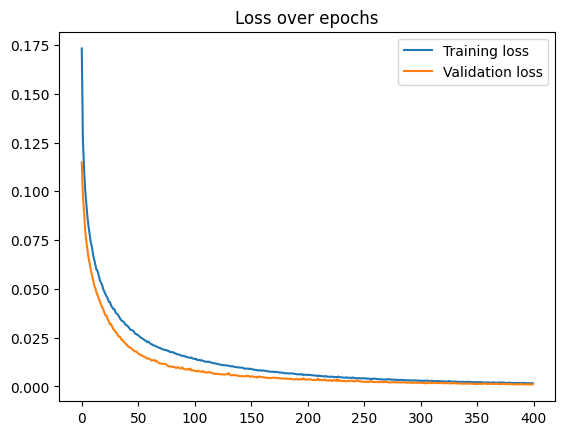

In [43]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# Save Model State for Further Training Later

In [51]:
checkpoint = {'state_dict' : model. state_dict(), 'optimizer': optimizer.state_dict()}

In [52]:
def save_checkpoint(state, filename = "model_checkpoint_3_2.pth.rar"):
    print("Saving current checkpoint")
    torch.save(state, filename)

In [53]:
save_checkpoint(checkpoint)

Saving current checkpoint


# Save Model for inferencing

In [54]:
# Save model for model inference
# Save the model's state_dict
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_3_2.pth.rar') # Save

# Test Trained model

In [44]:
import mediapipe as mp
import cv2

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.6, max_num_hands = 1)

In [45]:
def predict(model, input_landmarks):
    model.eval()
    with torch.no_grad():
        input_landmarks = torch.tensor(input_landmarks, dtype=torch.float32).flatten()
        input_landmarks = input_landmarks.unsqueeze(0).to(DEVICE)
        predictions_log = model(input_landmarks)
        predictions_prob = torch.exp(predictions_log)
        max_probability_predicted, max_probability_index = torch.max(predictions_prob, dim=1)
    return max_probability_index.item()

In [46]:
def hand_landmarks_detection(path: str) -> list:
    data_aux, x_, y_ = [], [], []

    img = cv2.imread(path)
    # Flip image horizontally to correctly identify left hand being used in the collected images
    #img = cv2.flip(img, 1)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    # Only use the images with left hand for dataset generation => only 21 points for landmarks
    if results.multi_hand_landmarks and results.multi_handedness[0].classification[0].label == 'Left':
        for hand_landmarks in results.multi_hand_landmarks:
            # Write images with overlapped hand landmarks on the original data collected.
            mp_drawing.draw_landmarks(
                img,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,  
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())
            
            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y

                x_.append(x)
                y_.append(y)

        # To reduce variability for different positions of the hand on the screen, each data point subtracts the lowest x and y position per frame.
        # Essentially reducing the positions of all landmarks to be start at the bottom left conner of the image.
        for i in range(len(hand_landmarks.landmark)):
            x = hand_landmarks.landmark[i].x
            y = hand_landmarks.landmark[i].y
            data_aux.append([x - min(x_), y - min(y_)])
    return data_aux
        

In [48]:
TEST_FOLDER_DIR = os.path.join(os.path.dirname(MAIN_DIR), "neural_net_model_test_set_after_ver3")
predicted, ground_truth = [], []
for char_folder in os.listdir(TEST_FOLDER_DIR):
    correct_result = char_folder
    for pic in os.listdir(os.path.join(TEST_FOLDER_DIR, char_folder)):
        hand_landmarks = hand_landmarks_detection(os.path.join(TEST_FOLDER_DIR, char_folder, pic))
        if hand_landmarks:
            predicted_result = predict(model, hand_landmarks)
            predicted.append(predicted_result)
            ground_truth.append(int(char_folder))

predicted = torch.tensor(predicted)
ground_truth = torch.tensor(ground_truth)

In [49]:
import torchmetrics
NUM_CLASSES = 29

accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES, average='macro')
precision = torchmetrics.Precision(task='multiclass', num_classes=NUM_CLASSES, average='macro')
recall = torchmetrics.Recall(task='multiclass', num_classes=NUM_CLASSES, average='macro')
f1score = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES, average='macro')

accuracy.update(predicted, ground_truth)
precision.update(predicted, ground_truth)
recall.update(predicted, ground_truth)
f1score.update(predicted, ground_truth)

In [50]:
# Compute and print results
print("Accuracy:", accuracy.compute())
print("Precision:", precision.compute())
print("Recall:", recall.compute())
print("F1 Score:", f1score.compute())

Accuracy: tensor(0.9077)
Precision: tensor(0.9037)
Recall: tensor(0.9077)
F1 Score: tensor(0.8992)
